In [246]:
import os
import random
import sys
import cv2
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Importation des données

In [2]:
!git clone https://github.com/MachineLearnia/breast_cancer_public_data.git

fatal: destination path 'breast_cancer_public_data' already exists and is not an empty directory.


In [3]:
folder_path = os.path.join("breast_cancer_public_data", "data_2")

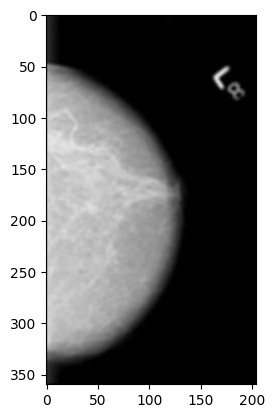

In [4]:
img = "breast_cancer_public_data/data_2/Cancer/1.jpg"
img = cv2.imread(img)
plt.imshow(img)

In [5]:
img.shape

(360, 204, 3)

In [180]:
# Train data preparation
classes =["Negative","Cancer"]
dataset = []

for class_label in classes:
    class_path=os.path.join(folder_path,class_label)
    label_index=classes.index(class_label)
    for img_file in tqdm.tqdm(os.listdir(class_path)):
        img_path=os.path.join(class_path, img_file)
        #img=cv2.imread(img_path)
        #img=cv2.resize(img,(224,224))
        #dataset.append([img,label_index])


        img = cv2.imread(img_path)
        if img is None:
            print("Image illisible :", img_path)
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        img = cv2.resize(img, (224, 224))

        dataset.append([img, label_index])

# Mélange du dataset (TRÈS IMPORTANT)
random.shuffle(dataset)

100%|██████████| 410/410 [00:00<00:00, 1252.88it/s]


In [181]:
dataset

[[array([[[  2,   2,   2],
          [  4,   4,   4],
          [  6,   6,   6],
          ...,
          [118, 118, 118],
          [ 96,  96,  96],
          [ 67,  67,  67]],
  
         [[  7,   7,   7],
          [ 10,  10,  10],
          [ 12,  12,  12],
          ...,
          [184, 184, 184],
          [152, 152, 152],
          [113, 113, 113]],
  
         [[ 11,  11,  11],
          [ 13,  13,  13],
          [ 16,  16,  16],
          ...,
          [203, 203, 203],
          [167, 167, 167],
          [124, 124, 124]],
  
         ...,
  
         [[  2,   2,   2],
          [  2,   2,   2],
          [  2,   2,   2],
          ...,
          [ 57,  57,  57],
          [ 48,  48,  48],
          [ 40,  40,  40]],
  
         [[  2,   2,   2],
          [  2,   2,   2],
          [  2,   2,   2],
          ...,
          [ 51,  51,  51],
          [ 44,  44,  44],
          [ 37,  37,  37]],
  
         [[  1,   1,   1],
          [  1,   1,   1],
          [  1,   1,   1

In [182]:
len(dataset)

820

# Normalization

In [183]:
x_images = []
y_images = []

for img,label in dataset:
    x_images.append(img)
    y_images.append(label)

X = np.array(x_images, dtype=np.float32) / 255.0
y = np.array(y_images) 

# Split the data into train/validation/test

In [194]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

X_val,X_test,y_val,y_test = train_test_split(X_test,y_test,test_size=0.5,stratify=y_test,random_state=42)

In [196]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(656, 224, 224, 3)
(82, 224, 224, 3)
(82, 224, 224, 3)


In [197]:
labels, counts = np.unique(y_train, return_counts=True)
print("Labels :", labels)
print("Counts :", counts)

Labels : [0 1]
Counts : [328 328]


Le dataset est équilibré

# Data augmentation (rotation, zoom, flips, etc.)

In [198]:
datagen = ImageDataGenerator(
    #rescale=1./255, 
    rotation_range=5,
    zoom_range=0.05,
    horizontal_flip=True
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

In [204]:
val_datagen = ImageDataGenerator()  
val_generator = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=False) # Si shuffle=True, Keras mélange les images à chaque epoch

# Train the model

In [205]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

c:\Users\nico_\Desktop\breast cancer detection\detectvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [206]:
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,601 (42.61 MB)

 Trainable params: 11,169,345 (42.61 MB)

 Non-trainable params: 256 (1.00 KB)

In [207]:
#model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [208]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1 )

In [209]:
history = model.fit(train_generator,epochs=30,validation_data=val_generator,callbacks=[early_stopping,checkpoint])

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6281 - loss: 0.7372
Epoch 1: val_accuracy improved from None to 0.53659, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.7195 - loss: 0.5701 - val_accuracy: 0.5366 - val_loss: 3.1135
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8454 - loss: 0.3523
Epoch 2: val_accuracy improved from 0.53659 to 0.78049, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8399 - loss: 0.3847 - val_accuracy: 0.7805 - val_loss: 0.6235
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8624 - loss: 0.3400
Epoch 3: val_accuracy did not improve from 0.78049
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 361ms/step - accuracy: 0.8857 - loss: 0.3025 - val_accuracy: 0.7561 - val_loss: 0.4751
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9114 - loss: 0.2640
Epoch 4: val_accuracy improved from 0.78049 to 0.91463, saving model to best_mo

# Visualization

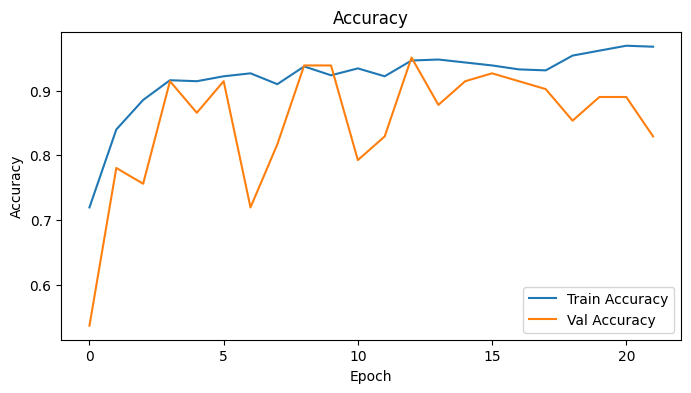

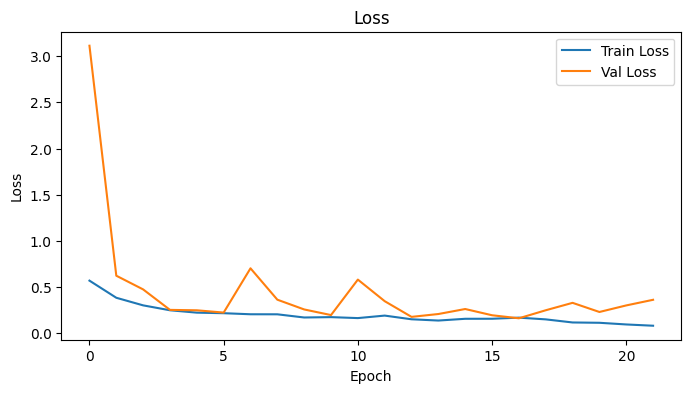

In [210]:
# Accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [211]:
best_model = load_model('best_model.keras')

In [212]:
loss, acc = best_model.evaluate(val_generator)
print(f"Best model accuracy: {acc:.4f}  |  loss: {loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9512 - loss: 0.1778
Best model accuracy: 0.9512  |  loss: 0.1778


In [216]:
y_pred_proba = best_model.predict(val_generator)

y_val_pred = (y_pred_proba > 0.5).astype(int)


precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc = roc_auc_score(y_val, y_pred_proba)  

print("Precision :", precision)
print("Recall    :", recall)
print("F1 score  :", f1)
print("ROC AUC   :", roc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Precision : 0.9743589743589743
Recall    : 0.926829268292683
F1 score  : 0.95
ROC AUC   : 0.9827483640690066


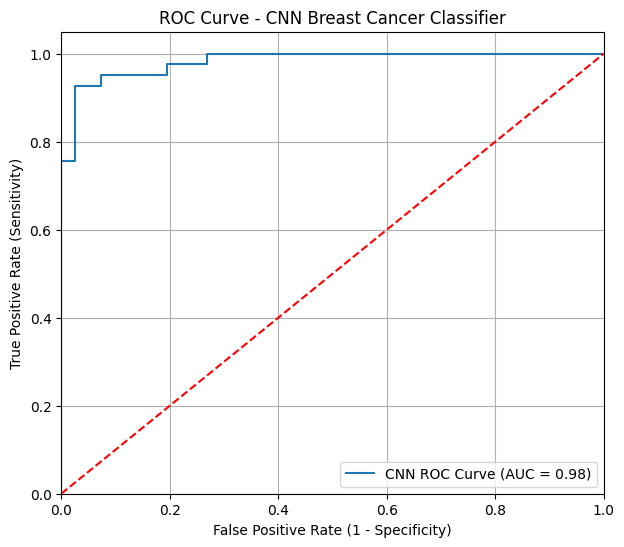

In [217]:
# Plot ROC AUC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# 4. AUC
auc_score = roc_auc_score(y_val, y_pred_proba)

# 5. Plot
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"CNN ROC Curve (AUC = {auc_score:.2f})")

# Ligne diagonale (hasard)
plt.plot([0, 1], [0, 1], 'r--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve - CNN Breast Cancer Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

[[78  4]
 [10 72]]


<Figure size 600x600 with 0 Axes>

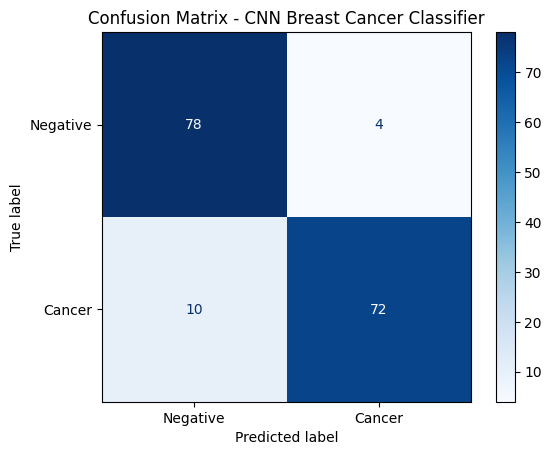

In [73]:
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Cancer"])

print(cm)

# 5. Affichage
plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - CNN Breast Cancer Classifier")
plt.show()


# Model test

In [218]:
model = load_model("best_model.keras")

In [239]:
def predict_test_image(index):

    # Récupérer image + label
    img = X_test[index]
    true_label = y_test[index]

    # Préparer pour prédiction
    img_input = np.expand_dims(img, axis=0)  # (1,224,224,3)

    # Prédiction
    pred = model.predict(img_input)[0][0]

    predicted_class = "Cancer" if pred > 0.5 else "Négatif"
    true_class = "Cancer" if true_label == 1 else "Négatif"

    # --- AFFICHAGE ---
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")

    # Titre principal : vérité terrain
    plt.title(f"Vérité terrain : {true_class}", fontsize=14)

    # Sous-titre : probabilité + classe prédite
    plt.suptitle(
        f"Probabilité prédite : {pred:.4f}  ->  Prédiction : {predicted_class}",
        y=0.02, fontsize=12, color="black"
    )

    plt.show()

    # Print console
    print(f"Vérité terrain : {true_class}")
    print(f"Probabilité prédite : {pred:.4f}")
    print(f"Prédiction du modèle : {predicted_class}")


In [240]:
len(X_test)

82

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


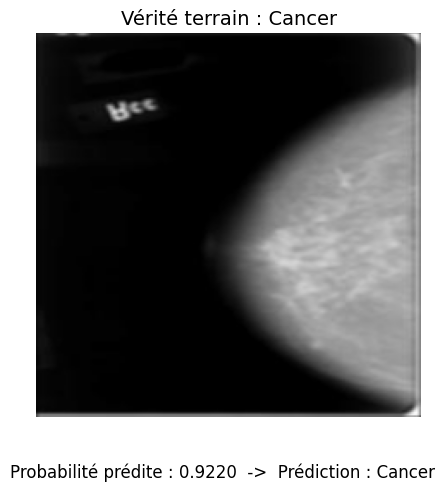

Vérité terrain : Cancer
Probabilité prédite : 0.9220
Prédiction du modèle : Cancer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


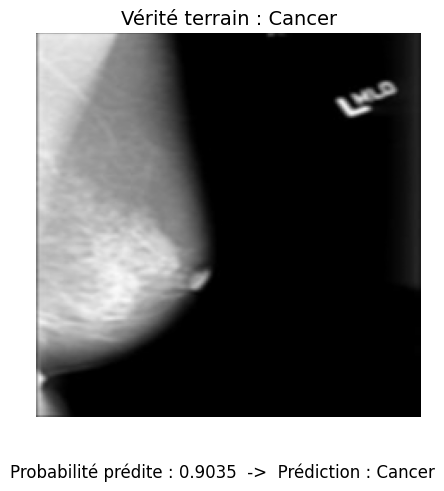

Vérité terrain : Cancer
Probabilité prédite : 0.9035
Prédiction du modèle : Cancer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


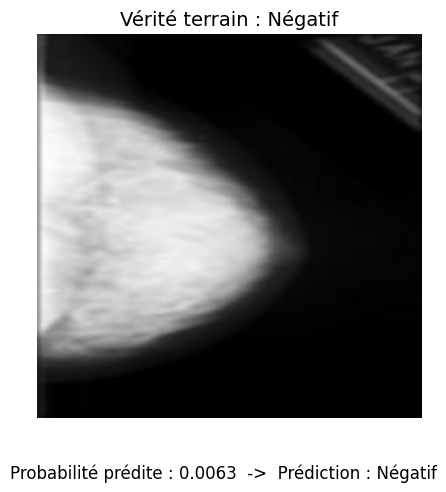

Vérité terrain : Négatif
Probabilité prédite : 0.0063
Prédiction du modèle : Négatif


In [241]:
predict_test_image(10)
predict_test_image(50)
predict_test_image(81)


In [ ]:
def predict_external_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertion BGR -> RGB
    img = cv2.resize(img, (224,224))
    img = img / 255.0  # normalisation identique
    img_input = np.expand_dims(img, axis=0) # Ajoute la dimension batch

    pred = model.predict(img_input)[0][0]

    plt.imshow(img)
    plt.title("Image externe")
    plt.axis('off')
    plt.show()

    print(f"Probabilité : {pred:.4f}")
    print("→ Prédiction :", "Cancer" if pred>0.5 else "Négatif")